In [60]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.neighbors import KernelDensity

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

sns.set_style('white')

%matplotlib inline

In [2]:
air = pd.read_csv('assets/datasets/airport_operations.csv')
air.columns = [c.replace(' ','_').replace('-','_') for c in air.columns]
air.head(2)

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [3]:
def proposal(statistic, proposal_distribution, step_size):
    proposed = proposal_distribution(statistic, step_size).rvs()
    return proposed

def log_likelihood(data, statistic, prior_distribution, prior_scale):
    loglike = prior_distribution(statistic, 1).logpdf(data)
    return np.sum(loglike)

def prior_logpdf(statistic, prior_distribution, prior_loc, prior_scale):
    prior_logpdf = prior_distribution(prior_loc, prior_scale).logpdf(statistic)
    return prior_logpdf

In [4]:
def metropolis_sampler(data, statistic, prior_distribution, prior_loc, prior_scale,
                       proposal_distribution, step_size=1):
    
    current_loglike = log_likelihood(data, statistic, prior_distribution, prior_scale)
    current_prior = prior_logpdf(statistic, prior_distribution, prior_loc, prior_scale)
   
    proposed = proposal(statistic, proposal_distribution, step_size)
    proposed_loglike = log_likelihood(data, proposed, prior_distribution, prior_scale)
    proposed_prior = prior_logpdf(proposed, prior_distribution, prior_loc, prior_scale)
    
    current_loglike_posterior = current_loglike + current_prior
    proposed_loglike_posterior = proposed_loglike + proposed_prior
    
    acceptance_criterion = np.exp(proposed_loglike_posterior - current_loglike_posterior)
    
    accept = acceptance_criterion > np.random.rand()
    
    if accept:
        return proposed
    else:
        return statistic
    
    

In [5]:
def markov_chain_monte_carlo(data, prior_distribution, prior_loc, prior_scale,
                             proposal_distribution, step_size=1, initial_statistic=0,
                             iterations=1000):
    
    statistic_posterior = [initial_statistic]
    current_statistic = initial_statistic
    
    for i in range(iterations):
        
        current_statistic = metropolis_sampler(data, current_statistic,
                                               prior_distribution,
                                               prior_loc, prior_scale,
                                               proposal_distribution,
                                               step_size=step_size)
        
        statistic_posterior.append(current_statistic)

        
    return statistic_posterior
    
    

In [106]:
data = air.average_taxi_out_time.values

prior_loc = np.mean(data)
prior_scale = 1.
prior_distribution = stats.norm
proposal_distribution = stats.norm

step_size=1.
initial_statistic = np.mean(data)
iterations = 10000
print prior_loc

13.7033888228


In [108]:
statistic_posterior = markov_chain_monte_carlo(data, prior_distribution,
                                               prior_loc, prior_scale,
                                               proposal_distribution,
                                               step_size=step_size, 
                                               initial_statistic=prior_loc,
                                               iterations=iterations)

In [109]:
def kde(x, data, bandwidth=0.5):
    # gaussian kde density
    data = np.array(data).reshape(-1, 1)
    kde_estimator = KernelDensity(bandwidth=bandwidth)
    density = np.exp(kde_estimator.fit(data).score_samples(data))
    return density


In [120]:
def plot_posterior_charts(data, statistic_posterior, prior_distribution,
                          prior_loc, prior_scale,
                          burn_buffer=30, burn_stop=100,
                          kde_detail=1.):
    
    # set up figure and axes
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(18,6))
    
    # get posterior with burn
    if len(statistic_posterior) > burn_buffer:
        burn = min(burn_stop, len(statistic_posterior)-burn_buffer)
    else:
        burn = 0
    
    posterior = statistic_posterior[burn:]

    ax1 = sns.distplot(data, color='grey', 
                       kde_kws={'lw':1.5, 'alpha':0.85},
                       hist_kws={'alpha':0.6}, ax=ax1,
                       norm_hist=False, bins=min(50, len(data)))
    
    #data_buffer = np.ptp(data)/10.
    #ax1.set_xlim([min(data)-data_buffer, max(data)+data_buffer])
    
    #x1_limits = ax1.get_xlim()
    #x1_granular = np.linspace(x1_limits[0], x1_limits[1], len(data))
    #print len(x1_granular)
    
    #prior = prior_distribution(prior_loc, prior_scale)
    #prior_density1 = prior.rvs(size=len(x1_granular))#np.exp(prior.logpdf(data))
    #ax1.plot(x1_granular, prior_density1, color='darkred', lw=1.5, alpha=0.85, normed=True)
    
    #prior_density1 = mlab.normpdf(x1_granular, prior_loc, prior_scale)
    #ax1.plot(x1_granular, prior.pdf(x1_granular),
    #        color='darkred', lw=2, alpha=0.3)
    
    #posterior_density1 = mlab.GaussianKDE(posterior).evaluate(x1_granular)
    #print posterior_density1
    #posterior_density1 = kde(x1_granular, posterior, bandwidth=kde_detail)
    #ax1.hist(posterior, color='steelblue', lw=1.5, alpha=0.85, normed=True)

    ax2 = sns.distplot(posterior, color='steelblue', 
                       kde_kws={'lw':1.5, 'alpha':0.85},
                       hist_kws={'alpha':0.6}, ax=ax2,
                       norm_hist=False, bins=min(25, len(posterior)))
    
    #ax2.set_ylim([0., max(posterior/np.sum(posterior))])
    
    #post_buffer = np.ptp(posterior)/10.
    #ax2.set_xlim([min(posterior)-post_buffer, max(posterior)+post_buffer])
    
    #x2_limits = ax2.get_xlim()
    #x2_granular = np.linspace(x2_limits[0], x2_limits[1], 1000)
    
    #prior_density2 = mlab.normpdf(x2_granular, prior_loc, prior_scale)
    #ax1.plot(x2_granular, prior_density2, color='darkred', lw=1.5, alpha=0.85)
    
    #prior_density2 = np.exp(prior.logpdf(x2_granular))
    #ax2.plot(prior_density2, color='darkred', lw=1.5, alpha=0.85)
    
    #print ax2.get_xlim()

    plt.show()

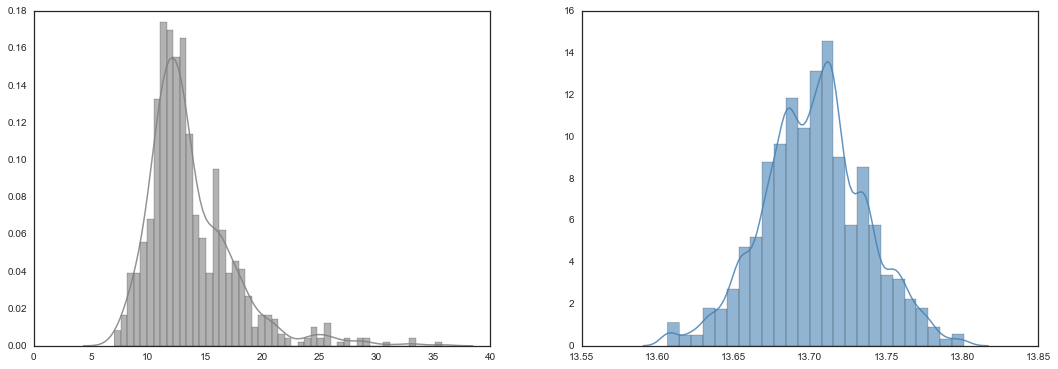

In [121]:
plot_posterior_charts(data, statistic_posterior, prior_distribution,
                      prior_loc, prior_scale,
                      burn_buffer=30, burn_stop=100, kde_detail=1.)